In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import test_s_curve

## Test dataset

In [3]:
# scurve_dataset = test_s_curve()
# expr_RNA = scurve_dataset[:]['RNA']
# # DPT distance
# DPT_RNA = diff.DPT_similarity(expr_RNA)
# # Phate distance
# Phate_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = True)
# # Diffmap distance
# Diffmap_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = False)

# DPT_tensor = torch.FloatTensor(DPT_RNA)
# Phate_tensor = torch.FloatTensor(Phate_RNA)
# Diffmap_tensor = torch.FloatTensor(Diffmap_RNA)

# fig = plt.figure(figsize = (20,10))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(X[:,0],X[:,1],X[:,2], c = color)

## Real dataset

In [2]:
class test_paul(Dataset):
    
    def __init__(self, file_path = "./data/Paul/Paul_processed_expr.csv"):
        self.expr_RNA = torch.FloatTensor(pd.read_csv(file_path, index_col=0).values)
        
        
    def __len__(self):
        # number of cells
        return len(self.expr_RNA)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # index denote the index of the cell
        sample = {'RNA':self.expr_RNA[idx,:], 'index':idx}
        
        return sample

In [3]:
## data 1, with ATAC ONE
# expr_RNA = pd.read_csv("./data/A549/self_processed/expr_rna.csv", index_col=0).values

# data 2, Paul data, give the best result
expr_RNA = pd.read_csv("./data/Paul/Paul_processed_expr.csv", index_col=0).values
cell_info = pd.read_csv("./data/Paul/Paul_cell_meta.txt", sep="\t")
clusters = cell_info['cell_type2']

# data 3, oeHBC data, small one 
# expr_RNA = pd.read_csv("./data/oeHBC/oeHBC_processed_expr.csv", sep = ",", index_col = 0).values
# clusters = pd.read_csv("./data/oeHBC/oeHBCdiff_clusterLabels.txt", sep='\t',header=None, index_col = 0, names=["cluster"])
# clusters = clusters['cluster'].astype('category')
# clusters = pd.DataFrame(clusters.cat.rename_categories(['Resting Horizontal Basal Cells (HBCs)', 'Immediate Neuronal Precursor 1 (INP1)', 'Globose Basal Cells (GBCs)', 'Mature Sustentacular Cells','Transitional HBC 2', 'Immature Sustentacular Cells', 'Transitional HBC 1', 'Immature Olfactory Sensory Neurons (iOSNs)', 'Immediate Neuronal Precursor 3 (INP3)', 'Microvillous Cells, type 1', 'Mature Olfactory Sensory Neurons (mOSNs)', 'Immediate Neuronal Precursor 2 (INP2)', 'Microvillous Cells, type 2']))

# data 4, linear dataset, forbrain
# expr_RNA = pd.read_csv("./data/forebrain/forebrain_processed_expr.csv", sep = ",", index_col = 0).values
# velo_RNA = pd.read_csv("./data/forebrain/forebrain_processed_velocity.csv", sep = ",", index_col = 0).values

# data_tensor = torch.FloatTensor(expr_RNA)

In [4]:
# diffu_RNA = diff.diffusion_map(expr_RNA, n_eign = None, alpha = 200, diffusion_time = 5)
# diff_sim = diff.diffusion_similarity(diffu_RNA)
# fig = plt.figure(figsize = (20,10))
# ax = fig.add_subplot()
# ax.scatter(diffu_RNA[:,2], diffu_RNA[:,3], c=np.arange(diffu_RNA.shape[0]))

# DPT distance
DPT_RNA = diff.DPT_similarity(expr_RNA)
# Phate distance
Phate_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = True)
# Diffmap distance
Diffmap_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = False)

DPT_tensor = torch.FloatTensor(DPT_RNA)
Phate_tensor = torch.FloatTensor(Phate_RNA)
Diffmap_tensor = torch.FloatTensor(Diffmap_RNA)

In [5]:
def traj_loss(recon_x, x, z, diff_sim, lamb_recon = 1, lamb_dist = 1):
    loss_recon = lamb_recon * F.mse_loss(recon_x, x)
    
    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    
    latent_sim = pairwise_distance(z)
#     print(np.isnan(latent_sim.detach().numpy()))
    
#     assert False
#     diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')
    
    # normalize latent similarity matrix
    latent_sim = latent_sim / torch.norm(latent_sim, p='fro')
    diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')

    # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
    loss_dist = - lamb_dist * torch.sum(diff_sim * latent_sim) 
    

    loss = loss_recon + loss_dist
    return loss, loss_recon, loss_dist

In [12]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    dist = torch.sqrt(dist + 1e-2)
    return dist 

In [13]:
dataset = test_paul()
train_loader = DataLoader(dataset, batch_size = 256, shuffle = True)
test_loader = DataLoader(dataset, batch_size = len(dataset), shuffle = False)

In [14]:
def train_model(model, data_loader, diff_sim, n_epochs = 100, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1):

    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    step = 0
    for epoch in range(n_epochs):
        for data in data_loader:
            batch_cols = data['index']
            batch_sim = diff_sim[batch_cols,:][:,batch_cols]
            batch_expr = data['RNA']
            batch_expr_r = model(batch_expr)
            z = model[:1](batch_expr)
            
            train_loss, loss_recon, loss_dist = traj_loss(batch_expr_r, batch_expr, z, batch_sim, lamb_r, lamb_d)
            
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        if epoch % 10 == 0:
            print("train loss: ", train_loss.item(), "loss_recon:", loss_recon.item(), "loss_dist:", loss_dist.item())
    


In [15]:
CONFIG = { 
    'in_features': expr_RNA.shape[1],
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
}


encoder = ae.Encoder(cfg = CONFIG)
decoder = ae.Decoder(cfg = CONFIG)
auto_encoder = nn.Sequential(encoder, decoder)

In [16]:
train_model(auto_encoder, train_loader, DPT_tensor, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1)

train loss:  -0.802669882774353 loss_recon: 0.18191930651664734 loss_dist: -0.9845892190933228
train loss:  -0.8540860414505005 loss_recon: 0.1426263302564621 loss_dist: -0.9967123866081238
train loss:  -0.8469130396842957 loss_recon: 0.15123063325881958 loss_dist: -0.9981436729431152
train loss:  -0.8538724184036255 loss_recon: 0.1438022404909134 loss_dist: -0.9976746439933777
train loss:  -0.8505173921585083 loss_recon: 0.14742788672447205 loss_dist: -0.9979453086853027
train loss:  -0.8511250615119934 loss_recon: 0.14701342582702637 loss_dist: -0.9981384873390198
train loss:  -0.8585461974143982 loss_recon: 0.1393003612756729 loss_dist: -0.9978465437889099
train loss:  -0.8412372469902039 loss_recon: 0.15606357157230377 loss_dist: -0.9973008036613464
train loss:  -0.8543786406517029 loss_recon: 0.14320683479309082 loss_dist: -0.9975854754447937
train loss:  -0.8673678636550903 loss_recon: 0.12997956573963165 loss_dist: -0.9973474144935608


## Real result

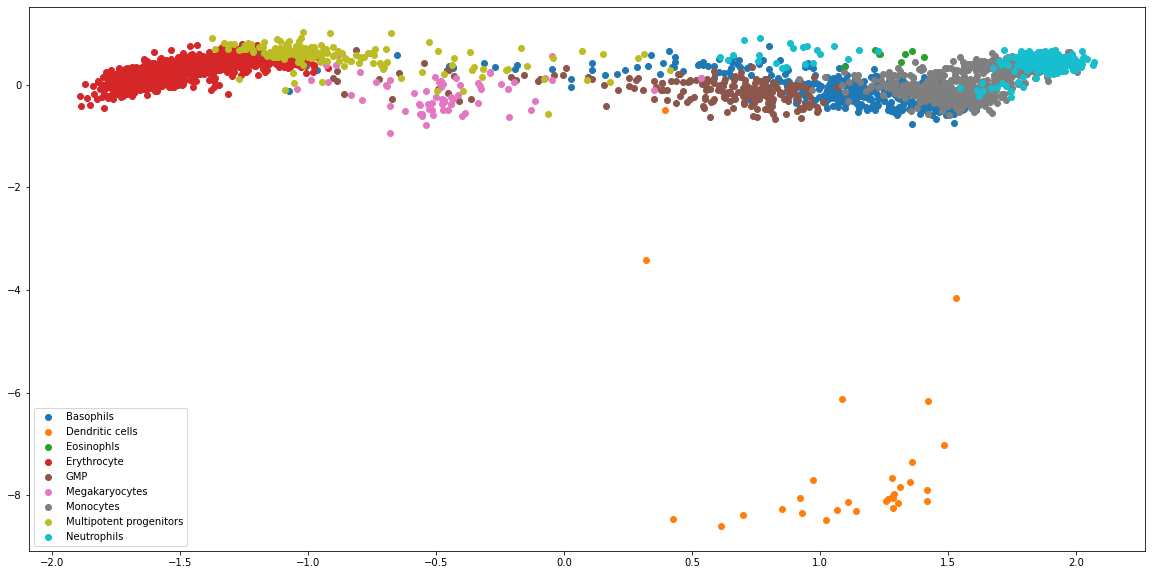

In [17]:
auto_encoder.eval()
for data in test_loader:
    ae_coordinates = auto_encoder[:1](data['RNA']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

# data 3, oeHBC data, small one 
cluster_types = np.unique(clusters.values)
colormap = plt.cm.get_cmap("tab10", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(clusters.values == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

## Test result

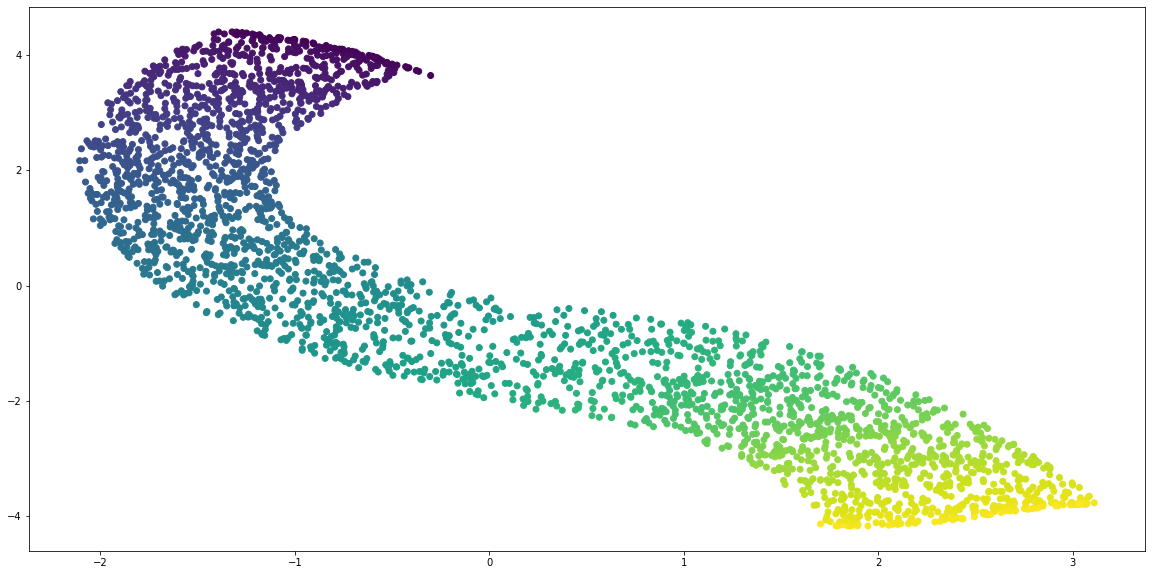

In [29]:
auto_encoder.eval()
for data in test_loader:
    ae_coordinates = auto_encoder[:1](data['RNA']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

ax.scatter(ae_coordinates[:,0],ae_coordinates[:,1], c = color)

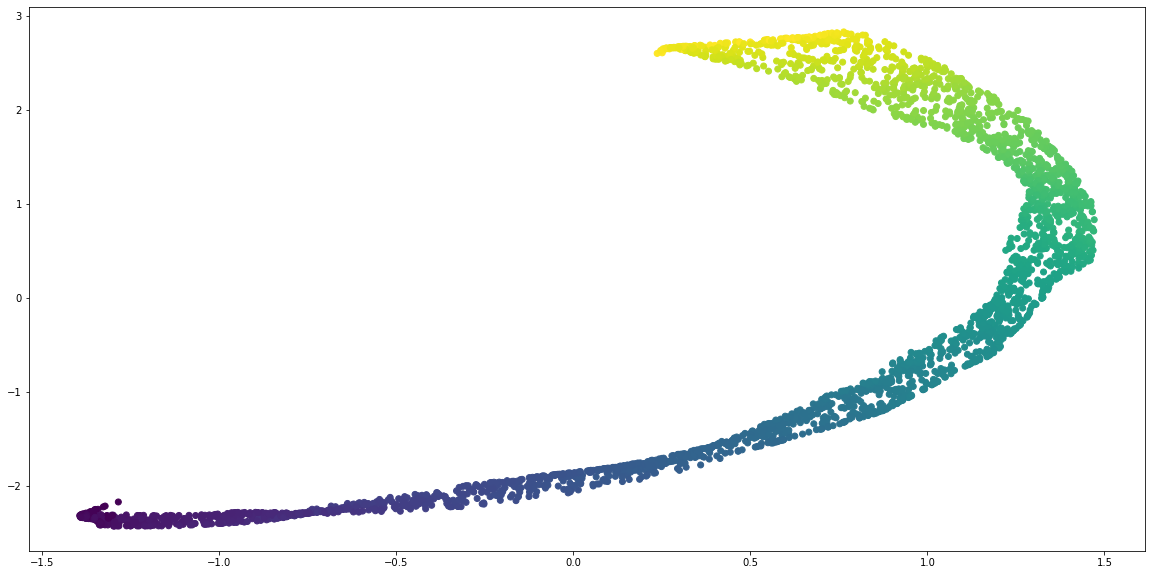

In [24]:
auto_encoder.eval()
for data in test_loader:
    ae_coordinates = auto_encoder[:1](data['RNA']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

ax.scatter(ae_coordinates[:,0],ae_coordinates[:,1], c = color)